In [1]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
pd.options.display.max_colwidth = 128
pylab.rcParams['figure.figsize'] = 12, 5
# with mpl.rc_context({"figure.figsize": (5, 5)}):
# with mpl.rc_context({"lines.linewidth": 2, "lines.color": "r"}):

Populating the interactive namespace from numpy and matplotlib


In [13]:
from skyfield.api import load, Topos
ts = load.timescale()
planets = load('de421.bsp')
earth, sun = planets['earth'], planets['sun']
sf = earth + Topos('37.7749 N', '122.4194 W')
TZ = -7
t6 = ts.utc(2018, 8, 19, 6 - TZ)
alt, az, distance = sf.at(t6).observe(sun).apparent().altaz()
print(alt)

-06deg 12' 11.4"


In [14]:
t7 = ts.utc(2018, 8, 19, 7 - TZ)
alt, az, distance = sf.at(t7).observe(sun).apparent().altaz()
print(alt)

05deg 08' 18.0"


```
plot([t6, t7], [?, ?])
```

In [19]:
t7 = ts.utc(2018, 8, 19, 7 - TZ)
alt, az, distance = sf.at(t7).observe(sun).apparent().altaz()
print(alt)

05deg 08' 18.0"


In [28]:
def f(hour):
    t = ts.utc(2018, 8, 19, array(hour) - TZ)
    alt, az, distance = sf.at(t).observe(sun).apparent().altaz()
    return alt.degrees

f(7)

5.1383290446332239

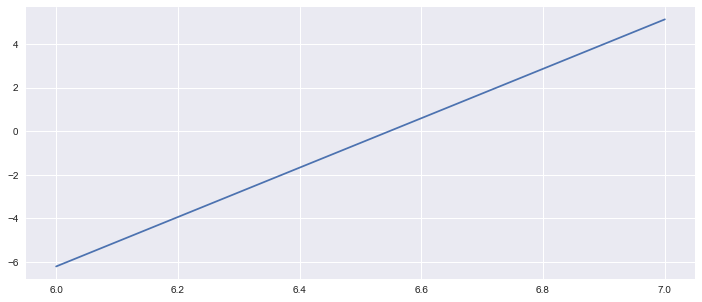

In [29]:
plot([6, 7], [f(6), f(7)])

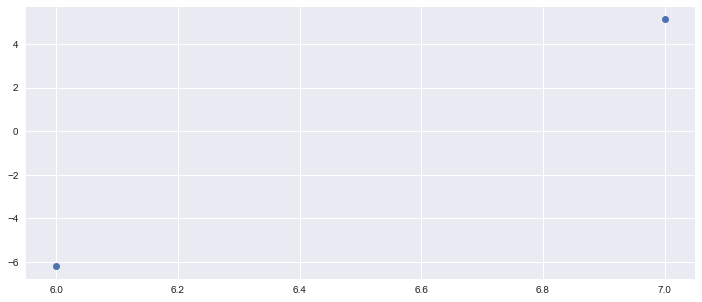

In [30]:
plot([6, 7], [f(6), f(7)], 'o')

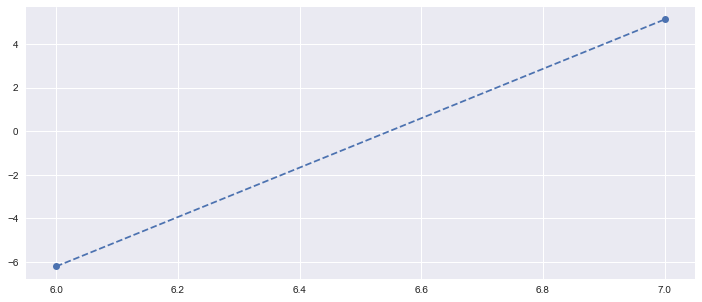

In [31]:
plot([6, 7], [f(6), f(7)], 'o--')

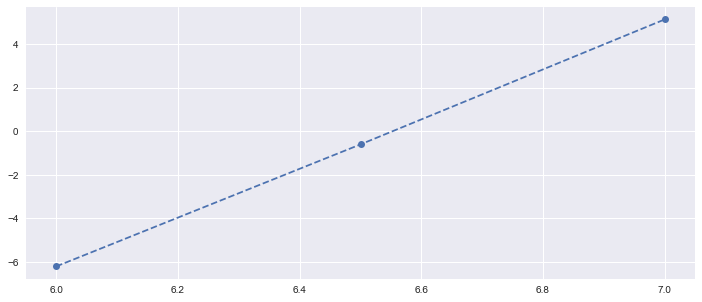

In [33]:
h = [6, 6.5, 7]
plot(h, f(h), 'o--')

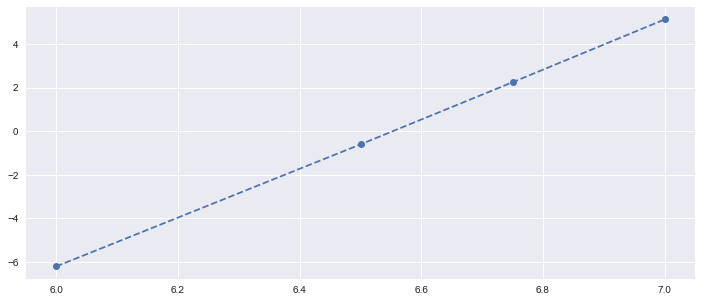

In [34]:
h = [6, 6.5, 6.75, 7]
plot(h, f(h), 'o--')

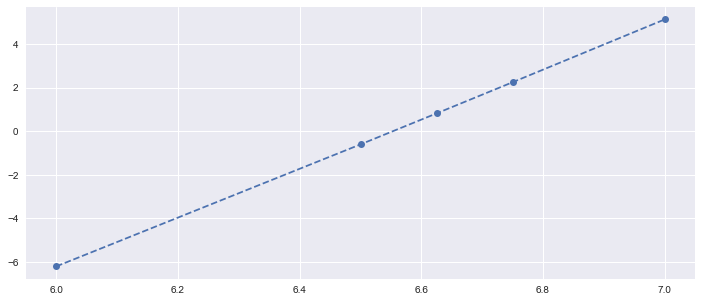

In [35]:
h = [6, 6.5, 6.625, 6.75, 7]
plot(h, f(h), 'o--')

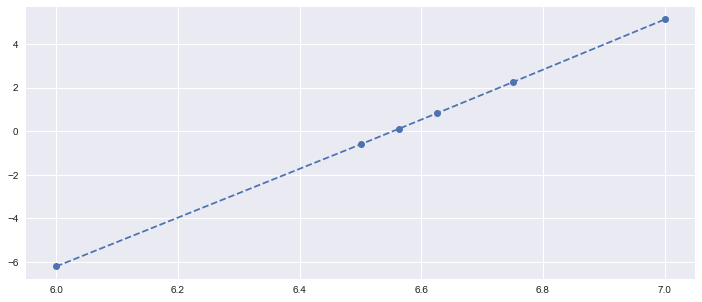

In [36]:
h = [6, 6.5, 6.5625, 6.625, 6.75, 7]
plot(h, f(h), 'o--')

In [47]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    hh = (h1 + h0) / 2
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

0.00135074888369 degrees = 4.86269598129 arcseconds


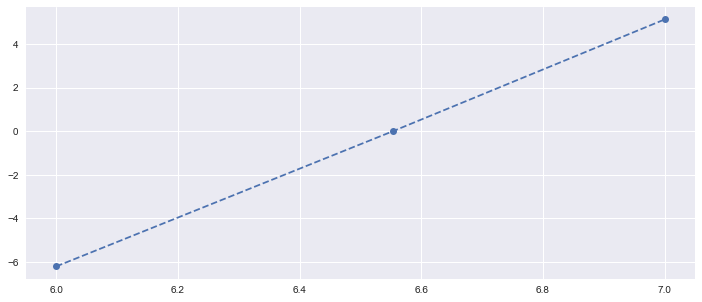

In [41]:
h = [6, hh, 7]
print(f(hh), 'degrees =', f(hh) * 3600, 'arcseconds')
plot(h, f(h), 'o--')

Q: At what expense?

In [45]:
interval_start = 7 - 6
interval_end = 1/3600
print(log10(interval_start / interval_end))
print(log(interval_start / interval_end) / log(2))

3.55630250077
11.8137811912


In [ ]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    hh = (h1 + h0) / 2  # <---
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

In [49]:
hh = (h1 + h0) / 2
hh = 0.5 * h1 + 0.5 * h0
hh = 0.4 * h1 + 0.6 * h0
hh = h0 + f(h0) * (f(h1) - f(h0))

In [69]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    fraction1 = 0.5
    #print(h0 * 0.5, h1 * 0.5)
    hh = fraction1 * h1 + (1 - fraction1) * h0
    print(hh, h1 - h0)
    #break
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh

6.5 1
6.75 0.5
6.625 0.25
6.5625 0.125
6.53125 0.0625
6.546875 0.03125
6.5546875 0.015625
6.55078125 0.0078125
6.552734375 0.00390625
6.5537109375 0.001953125
6.55322265625 0.0009765625
6.552978515625 0.00048828125


In [71]:
h0 = 6
h1 = 7
while h1 - h0 > 1/3600:
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    if f(hh) > 0:
        h1 = hh
    else:
        h0 = hh
    print(hh, h1-h0)

6.54694463859 0.453055361411
6.5528044219 0.447195578104
6.55285933664 0.447140663355
6.5528598582 0.447140141797
6.55285985941 0.447140140588
6.55285986062 0.447140139379
6.55285986183 0.447140138171
6.55285986304 0.447140136962
6.55285986425 1.20867937881e-09


In [77]:
h0 = 6
h1 = 7
while abs(h1 - h0) > 1/3600:
    num = h0 * f(h1) - h1 * f(h0)
    denom = f(h1) - f(h0)
    hh = num / denom
    h0, h1 = h1, hh
    print(h0, h1, h1-h0)

7 6.54694463859 -0.453055361411
6.54694463859 6.5528044219 0.00585978330672
6.5528044219 6.55285986302 5.54411210123e-05
